In [1]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments'),
    ('order_items.csv','order_items')# Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='asdfjkl',
    database='ecommerce'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = 'D:/Data Analyst/python and sql'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Processing products.csv
NaN values before replacement:
product_id                      0
product category              610
product_name_length           610
product_description_length    610
product_photos_qty            610
prod

In [2]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install mysql-connector-python

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as pd
import seaborn as sea
import mysql.connector
import matplotlib.pyplot as plt

In [6]:
#connection establish
db = mysql.connector.connect(
    host='localhost',
    user='root',
    password='asdfjkl',
    database='ecommerce'
)

#activate the cursor
cursor = db.cursor()

# List all unique cities where customers are located

In [7]:
query = """ select distinct customer_city from customers"""

#to execute the query
cursor.execute(query)

#to fetch the data
data = cursor.fetchall()

df=pd.DataFrame(data)
df.head()

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


# Count the number of orders placed in 2017.

In [8]:
query = """ select count(order_id) from orders where year(order_purchase_timestamp) = 2017 """

#to execute the query
cursor.execute(query)

#to fetch the data
data = cursor.fetchall()

data[0][0]

631414

# Find the total sales per category

In [9]:
query = """select upper(products.product_category) category ,
round(sum(payments.payment_value),2) sales
from products 
join order_items 
on products.product_id = order_items.product_id
join payments 
on payments.order_id = order_items.order_id
group by category
"""

#to execute the query
cursor.execute(query)

#to fetch the data
data = cursor.fetchall()
df=pd.DataFrame(data ,columns=['category','sales'])
df

,category,sales
0,PERFUMERY,5.335958e+08
1,FURNITURE DECORATION,1.505976e+09
2,TELEPHONY,5.126868e+08
3,BED TABLE BATH,1.803319e+09
4,AUTOMOTIVE,8.974659e+08
...,...,...
69,CDS MUSIC DVDS,1.263000e+06
70,LA CUISINE,3.067947e+06
71,FASHION CHILDREN'S CLOTHING,8.273105e+05
72,PC GAMER,2.289675e+06


# Caluculate the percentage orders that were paid in installment

In [10]:
query = """select sum(case when payment_installments >=1 then 1 else 0 end )/count(*)*100 from payments"""

#to execute the query
cursor.execute(query)

#to fetch the data
data = cursor.fetchall()
data

[(Decimal('99.9981'),)]

# Count the number of customers from each state

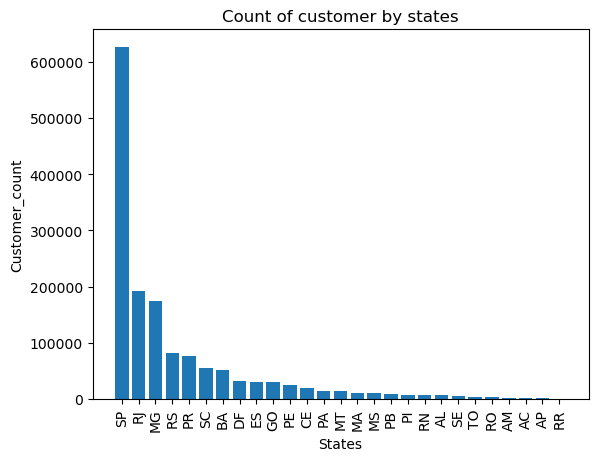

In [11]:
query = """select customer_state,count(customer_id) from customers group by customer_state"""

#to execute the query
cursor.execute(query)

#to fetch the data
data = cursor.fetchall()
df=pd.DataFrame(data,columns=["State",'Customers count'])
df=df.sort_values(by="Customers count",ascending=False)
plt.bar(df["State"],df['Customers count'])
plt.ylabel("Customer_count")
plt.xlabel("States")
plt.title("Count of customer by states")
plt.xticks(rotation=90)
plt.show()

# Calculate the numbers of orders per month in 2018

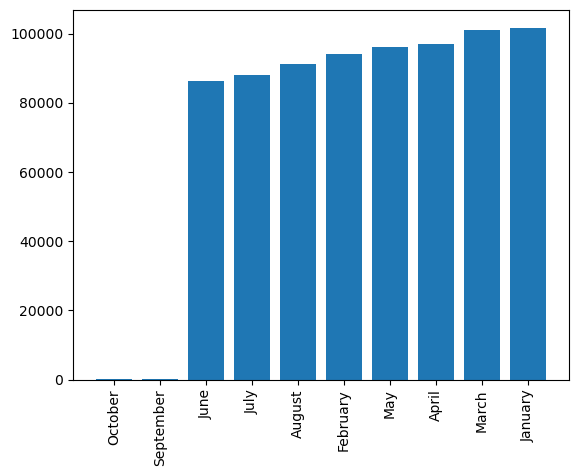

In [12]:
query = """select monthname(order_purchase_timestamp) months ,count(order_id) order_count from orders where year(order_purchase_timestamp)=2018 group by months """

#to execute the query
cursor.execute(query)

#to fetch the data
data = cursor.fetchall()
df=pd.DataFrame(data,columns=["Months","orders"])
df=df.sort_values(by="orders",ascending=True)
plt.bar(df["Months"],df['orders'])
plt.xticks(rotation=90)
plt.show()

# OR

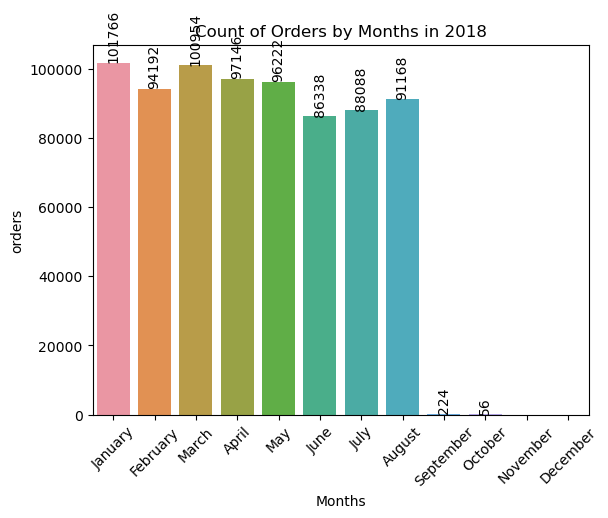

In [13]:
query = """select monthname(order_purchase_timestamp) months ,count(order_id) order_count from orders where year(order_purchase_timestamp)=2018 group by months """

#to execute the query
cursor.execute(query)

#to fetch the data
data = cursor.fetchall()
df=pd.DataFrame(data,columns=["Months","orders"])
o=["January","February","March","April","May","June","July","August","September","October","November","December"]
ax=sea.barplot(x=df["Months"],y=df['orders'],data=df,order=o)
ax.bar_label(ax.containers[0],rotation=90)
plt.xticks(rotation=45)
plt.title("Count of Orders by Months in 2018")
plt.show()

# Find the avg number of products per order Grouped by customer city 

In [14]:
query = """with count_per_order as 
(select orders.order_id, orders.customer_id, count(order_items.order_id) as oc
from orders join order_items
on orders.order_id = order_items.order_id
group by orders.order_id, orders.customer_id)

select customers.customer_city, round(avg(count_per_order.oc),2) average_orders
from customers join count_per_order
on customers.customer_id = count_per_order.customer_id
group by customers.customer_city order by average_orders desc
"""

cursor.execute(query)

data = cursor.fetchall()
df = pd.DataFrame(data,columns = ["customer city", "average products/order"])
df.head(10)

,customer city,average products/order
0,padre carvalho,882.00
1,celso ramos,819.00
2,datas,756.00
3,candido godoi,756.00
4,matias olimpio,630.00
5,cidelandia,504.00
6,curralinho,504.00
7,picarra,504.00
8,morro de sao paulo,504.00
9,teixeira soares,504.00


# Calculate the percentage of total revenue contributed by each product category

In [15]:
query = """select upper(products.product_category) category, 
round((sum(payments.payment_value)/(select sum(payment_value) from payments))*100,2) sales_percentage
from products join order_items 
on products.product_id = order_items.product_id
join payments 
on payments.order_id = order_items.order_id
group by category order by sales_percentage desc"""


cursor.execute(query)
data = cursor.fetchall()
df = pd.DataFrame(data,columns = ["Category", "percentage distribution"])
df.head()

,Category,percentage distribution
0,BED TABLE BATH,1251.61
1,HEALTH BEAUTY,1211.28
2,COMPUTER ACCESSORIES,1158.63
3,FURNITURE DECORATION,1045.24
4,WATCHES PRESENT,1044.54


# Identify the corelational between product price and the number of times the product has purchased 

In [16]:
import mysql.connector
import numpy as np
import pandas as pd

# Establish Connection (Modify with Your Credentials)
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='asdfjkl',
    database='ecommerce'
)


# Check if connection is alive
conn.ping(reconnect=True)

# Create Cursor
cursor = conn.cursor()

# SQL Query
query = """
SELECT products.product_category, 
       COUNT(order_items.product_id),
       ROUND(AVG(order_items.price), 2)
FROM products 
JOIN order_items ON products.product_id = order_items.product_id
GROUP BY products.product_category
"""

# Execute Query
cursor.execute(query)
data = cursor.fetchall()



# Create DataFrame
df = pd.DataFrame(data, columns=["Category", "order_count", "price"])

# Convert columns to numeric type for correlation calculation
df["order_count"] = df["order_count"].astype(float)
df["price"] = df["price"].astype(float)

# Calculate Correlation
a = np.corrcoef(df["order_count"], df["price"])
print("The correlation is", a[0, 1])




The correlation is -0.1063151416715756


# Calculate the total revenue generated by each seller and rank them by revenue

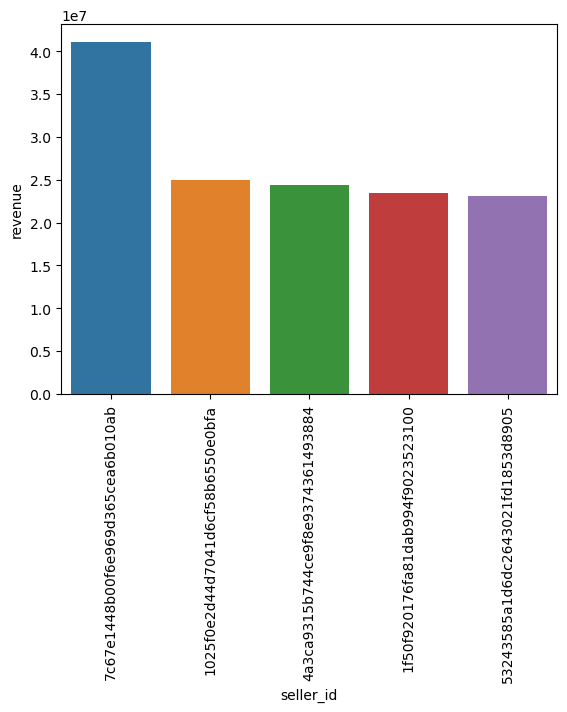

In [17]:
query = """ select *, dense_rank() over(order by revenue desc) as rn from
(select order_items.seller_id, sum(payments.payment_value)
revenue from order_items join payments
on order_items.order_id = payments.order_id
group by order_items.seller_id) as a """

cursor.execute(query)
data = cursor.fetchall()
df = pd.DataFrame(data, columns = ["seller_id", "revenue", "rank"])
df = df.head()
sea.barplot(x = "seller_id", y = "revenue", data = df)
plt.xticks(rotation = 90)
plt.show()

# Calculate the moving average of order values for each customer over their order history

In [18]:
query = """select customer_id, order_purchase_timestamp, payment,
avg(payment) over(partition by customer_id order by order_purchase_timestamp
rows between 2 preceding and current row) as mov_avg
from
(select orders.customer_id, orders.order_purchase_timestamp, 
payments.payment_value as payment
from payments join orders
on payments.order_id = orders.order_id) as a"""
cursor.execute(query)
data = cursor.fetchall()
df = pd.DataFrame(data)
df

,0,1,2,3
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
2,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
3,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
4,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
...,...,...,...,...
13089631,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
13089632,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
13089633,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
13089634,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001


# Calculate the cumulative sales per month for each year

In [19]:
query = """select years, months , payment, sum(payment)
over(order by years, months) cumulative_sales from 
(select year(orders.order_purchase_timestamp) as years,
month(orders.order_purchase_timestamp) as months,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years, months order by years, months) as a
"""
cursor.execute(query)
data = cursor.fetchall()
df = pd.DataFrame(data)
df

,0,1,2,3
0,2016,9,3.178224e+04,3.178224e+04
1,2016,10,7.445400e+06,7.477183e+06
2,2016,12,2.472120e+03,7.479655e+06
3,2017,1,1.744949e+07,2.492915e+07
4,2017,2,3.678041e+07,6.170956e+07
5,2017,3,5.668281e+07,1.183924e+08
6,2017,4,5.264129e+07,1.710337e+08
7,2017,5,7.470777e+07,2.457414e+08
8,2017,6,6.442082e+07,3.101623e+08
9,2017,7,7.464025e+07,3.848025e+08


# Calculate the year-over-year growth rate of total sales

In [20]:
query = """with a as(select year(orders.order_purchase_timestamp) as years,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years order by years)

select years, ((payment - lag(payment, 1) over(order by years))/
lag(payment, 1) over(order by years)) * 100 from a"""

cursor.execute(query)
data = cursor.fetchall()
df = pd.DataFrame(data, columns = ["years", "yoy % growth"])
df

,years,yoy % growth
0,2016,NaN
1,2017,12112.703758
2,2018,20.000924


# Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase

In [21]:
query = """with a as (select customers.customer_id,
min(orders.order_purchase_timestamp) first_order
from customers join orders
on customers.customer_id = orders.customer_id
group by customers.customer_id),

b as (select a.customer_id, count(distinct orders.order_purchase_timestamp) next_order
from a join orders
on orders.customer_id = a.customer_id
and orders.order_purchase_timestamp > first_order
and orders.order_purchase_timestamp < 
date_add(first_order, interval 6 month)
group by a.customer_id) 

select 100 * (count( distinct a.customer_id)/ count(distinct b.customer_id)) 
from a left join b 
on a.customer_id = b.customer_id ;"""

cursor.execute(query)
data = cursor.fetchall()

data

[(None,)]

# Identify the top 3 customers who spent the most money in each year.

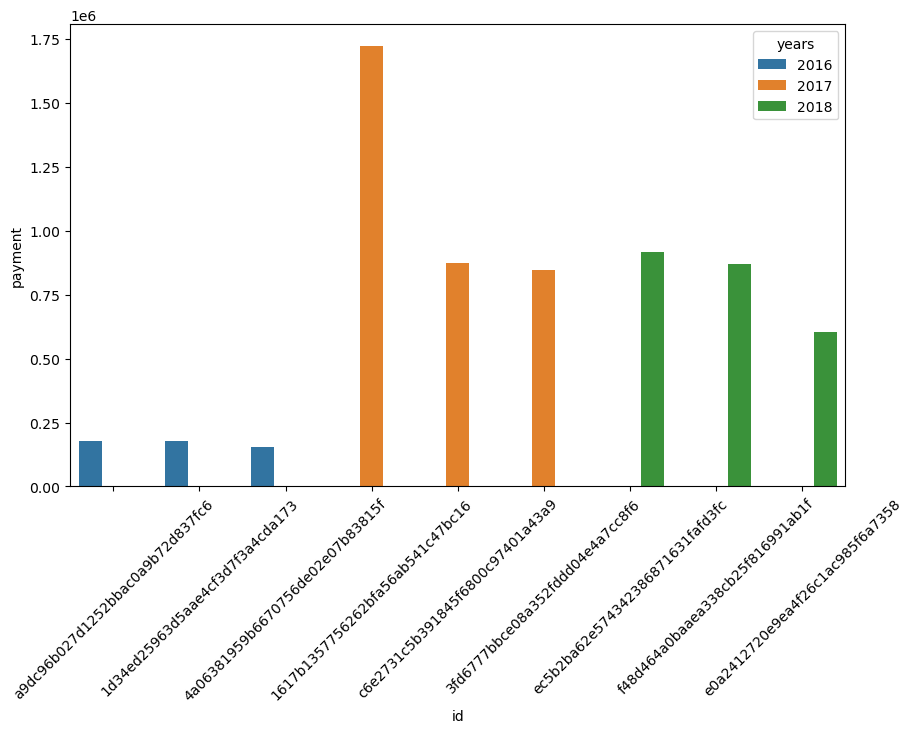

In [22]:
import pandas as pd
import seaborn as sea
import matplotlib.pyplot as plt

# SQL Query
query = """
SELECT years, customer_id, payment, d_rank
FROM (
    SELECT 
        YEAR(orders.order_purchase_timestamp) AS years,
        orders.customer_id,
        SUM(payments.payment_value) AS payment,
        DENSE_RANK() OVER (PARTITION BY YEAR(orders.order_purchase_timestamp) 
                           ORDER BY SUM(payments.payment_value) DESC) AS d_rank
    FROM orders 
    JOIN payments ON payments.order_id = orders.order_id
    GROUP BY YEAR(orders.order_purchase_timestamp), orders.customer_id
) AS a
WHERE d_rank <= 3;
"""

# Execute the query
cursor.execute(query)
data = cursor.fetchall()

# Create DataFrame
df = pd.DataFrame(data, columns=["years", "id", "payment", "rank"])

# Convert 'id' and 'years' to strings for correct Seaborn plotting
df["id"] = df["id"].astype(str)
df["years"] = df["years"].astype(str)

# Plot using Seaborn
plt.figure(figsize=(10, 6))
sea.barplot(x="id", y="payment", data=df, hue="years")

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)
plt.show()
